# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Cats-and-Dogs-(1):-Aumentando-os-dados" data-toc-modified-id="Cats-and-Dogs-(1):-Aumentando-os-dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (1): Aumentando os dados</a></div><div class="lev2 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Aumentando-o-dataset" data-toc-modified-id="Aumentando-o-dataset-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Aumentando o dataset</a></div><div class="lev2 toc-item"><a href="#Procedimento-de-treino" data-toc-modified-id="Procedimento-de-treino-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Procedimento de treino</a></div><div class="lev2 toc-item"><a href="#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Construção da rede neural</a></div><div class="lev2 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev2 toc-item"><a href="#Avaliação" data-toc-modified-id="Avaliação-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliação</a></div><div class="lev2 toc-item"><a href="#Treinamento-sem-aumento-de-dados" data-toc-modified-id="Treinamento-sem-aumento-de-dados-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Treinamento sem aumento de dados</a></div><div class="lev2 toc-item"><a href="#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Aprendizados com este notebook</a></div>

# Cats and Dogs (1): Aumentando os dados

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Este é o primeiro de 3 experimentos que ilustram a importância da transferência de conhecimento (*transfer learning*), isto é, utilizar pesos de redes já treinadas em outras aplicações.

Utiliza-se aqui uma rede convolucional com mais de 1 milhão de parâmetros a serem treinados. O treinamento é feito de uma rede com inicialização padrão do Keras.

Este notebook ilustra a técnica de *data augmentation*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models', exist_ok=True)
nr.seed(20170603)

Using TensorFlow backend.


Keras  2.0.4


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    CatsDogs/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

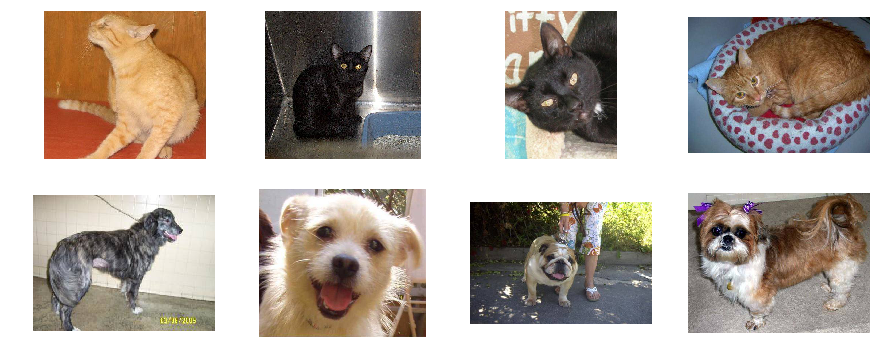

In [3]:
train_data_dir = '../../datasets/CatsDogs/train'
validation_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

N = 4
image_filenames = []
fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, N)):  # mostrando N gatos e N cachorros de forma aleatória
    fig.add_subplot(2, N, i+1)
    fn = '{}/cats/cat.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)
    plot.axis('off')
    image_filenames.append(fn)
    
    fig.add_subplot(2, N, i+N+1)
    fn = '{}/dogs/dog.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)    
    plot.axis('off')
    image_filenames.append(fn)



## Aumentando o dataset


In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
       rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

train_datagen_no_augm = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

Mostrando o funcionamento do ImageDataGenerator para 8 imagens, 4 cachorros e 4 gatos

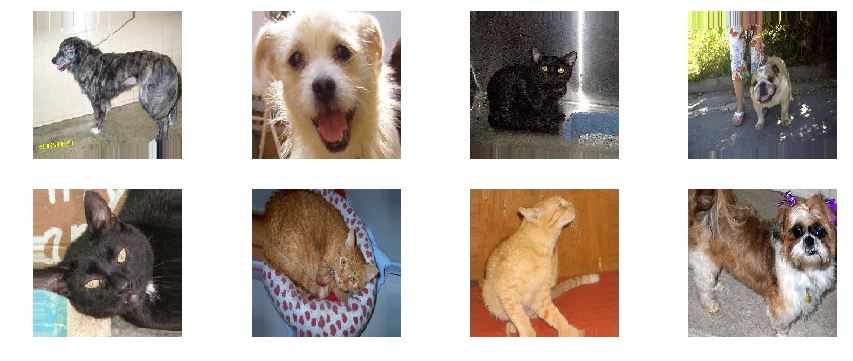

In [5]:
X_s = np.empty((2*N, 150, 150, 3), np.uint8)
y_s = np.empty((2*N,), np.int32)
for i, fn in enumerate(image_filenames):
    y_s[i] = 1 if fn.split('/')[-2] == 'dogs' else 0
    img = load_img(fn, grayscale=False, target_size=(150, 150))
    X_s[i] = img_to_array(img, data_format=image_format)

# Criação do generator
generator = train_datagen.flow(X_s, y_s, batch_size=8)  # 

X, y = generator.next()

fig = plot.figure(figsize=(15,6))
for i, img in enumerate(X):
    fig.add_subplot(2, 4, i+1)
    plot.imshow(img)
    plot.axis('off')
    

In [6]:
batch_size = 40

train_generator_no_augm = train_datagen_no_augm.flow_from_directory(
        train_data_dir,                       
        target_size=(img_width, img_height),
        batch_size=batch_size,              
        class_mode='binary')

train_generator = train_datagen.flow_from_directory(
        train_data_dir,                       # as amostras de treinamento
        target_size=(img_width, img_height),
        batch_size=batch_size,                # batch size do SGD
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,                  # as amostras de validação
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Procedimento de treino

In [7]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Construção da rede neural
A rede neural utilizada é especificada a seguir.

In [8]:
model_name = '../../models/cats_dogs_1'

def build_net(img_width, img_height):
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

model = build_net(img_width, img_height)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

## Treinamento

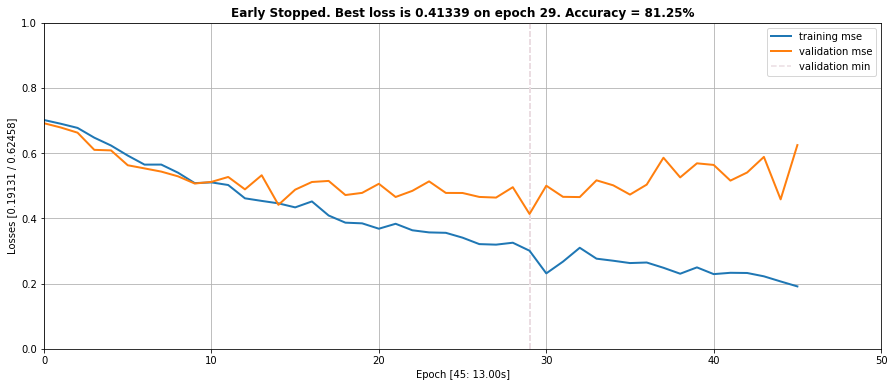

In [9]:
fit_params = {
    'train_steps':     nb_train_samples / batch_size,
    'valid_steps':     nb_validation_samples / batch_size,
    'opt':             'adam',    # SGD(lr=0.1, momentum=0.9, nesterov=True), 
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           False,
}

train_network(model, model_name, train_generator, validation_generator, **fit_params);

## Avaliação

In [10]:
test_network(model_name, validation_generator, nb_validation_samples / batch_size)

Model from epoch 29
[INFO] evaluating in the test data set ...

[INFO] accuracy on the test data set: 80.25% [0.44268]


## Treinamento sem aumento de dados

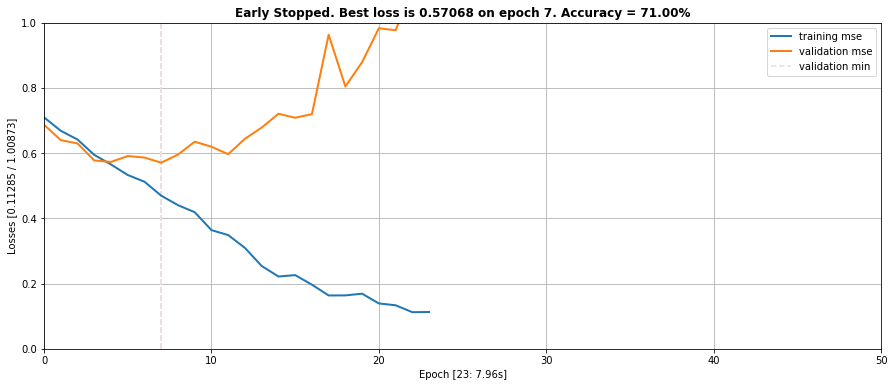

In [11]:
fit_params = {
    'train_steps':     nb_train_samples / batch_size,
    'valid_steps':     nb_validation_samples / batch_size,
    'opt':             'adam',    # SGD(lr=0.1, momentum=0.9, nesterov=True), 
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           False,
}

train_network(model, model_name.replace('_1', '_no_augm_1'), train_generator_no_augm, validation_generator, **fit_params);

## Aprendizados com este notebook

1. DataGenerator - o Keras possui um gerador sintético de dados onde transformações aleatórias são aplicadas no conjunto de treinamento. Esta transformação está sendo aplicada *on the fly*. É uma forma de regularização, permitindo maior generalização do classificador. O treinamento da rede com o gerador de dados resulta numa acurácia nos dados de validação de 80%.
2. O treinamento desta rede sem o uso do gerador aleatório de transformações resulta numa acurácia de 70%, com um early stopping bem rápido (época)
